# Data Mining Project

## Index
1. [Introduction](#introduction)
2. [Data Collection](#data-collection)
3. [Data Preprocessing](#data-preprocessing)
4. [Exploratory Data Analysis (EDA)](#eda)
5. [Feature Engineering](#feature-engineering)
6. [Model Selection and Training](#model-selection)
7. [Model Evaluation](#model-evaluation)
8. [Conclusion](#conclusion)  

1. <a name="introduction"></a>Introduction
   - Overview of the project
   - Objectives and goals

2. <a name="data-collection"></a>Data Collection
   - Description of data sources
   - Methods of data collection

3. <a name="data-preprocessing"></a>Data Preprocessing
   - Data cleaning techniques
   - Handling missing values
   - Data transformation and normalization

4. <a name="eda"></a>Exploratory Data Analysis (EDA)
   - Summary statistics
   - Data visualization techniques
   - Identifying patterns and trends

5. <a name="feature-engineering"></a>Feature Engineering
   - Feature selection methods
   - Creating new features
   - Dimensionality reduction techniques

6. <a name="model-selection"></a>Model Selection and Training
   - Overview of algorithms considered
   - Training procedures
   - Hyperparameter tuning

7. <a name="model-evaluation"></a>Model Evaluation
   - Evaluation metrics
   - Cross-validation results
   - Comparison of model performance

8. <a name="conclusion"></a>Conclusion
   - Summary of findings
   - Future work and improvements

In [27]:
import sqlite3
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from scipy.stats import skewnorm

from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

## DATA WRANGLING CUSTOMERS

In [28]:
customers = pd.read_csv("https://raw.githubusercontent.com/catamina07/datamining-group/main/data/DM_AIAI_CustomerDB.csv")
customers.head()

,Unnamed: 0,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,...,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,...,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,...,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,...,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
3,3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,...,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
4,4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,...,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


In [29]:
#How many countries are represented in the dataset?
print(customers['Country'].nunique())
print(customers['Country'].unique())

1
['Canada']


In [30]:
# is a redundant feature, since is the only country in the dataset
customers.drop(columns="Country",inplace=True)

In [31]:
# Drop the columns "First Name" and "Last Name" as they are not relevant for our analysis, a
# nd they contain many unique values that are already represented in the "Customer Name" column
customers.drop(columns=["First Name", "Last Name"], inplace=True)

In [32]:
# Checking for duplicates
print(f"Number of duplicate rows: {customers.duplicated().sum()}")

Number of duplicate rows: 0


In [33]:
# Checiking if there are two or more instances with the same LoyaltyCardNumber
print(f"Number of duplicate LoyaltyCardNumber: {customers['Loyalty#'].duplicated().sum()}")


Number of duplicate LoyaltyCardNumber: 164


In [34]:
# Show all rows where Loyalty# is duplicated
duplicates = customers[customers['Loyalty#'].duplicated(keep=False)]

# Count frequency of each Loyalty#
dup_counts = customers['Loyalty#'].value_counts()
duplicates_only = dup_counts[dup_counts > 1]
print("Duplicate Loyalty numbers and counts:")
duplicates_only

print("Number of unique Loyalty numbers that are duplicated:", len(duplicates_only))
print("Total rows involved in duplicates:", duplicates_only.sum())



Duplicate Loyalty numbers and counts:
Number of unique Loyalty numbers that are duplicated: 163
Total rows involved in duplicates: 327


In [35]:
#How many unique loyalty card numbers are there?
print(customers['Loyalty#'].nunique())

16757


In [36]:
customers[customers['Loyalty#'] == 678205]

,Unnamed: 0,Loyalty#,Customer Name,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
9546,9546,678205,Arnold Sirles,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Urban,48448.0,Married,Nova,9/27/2018,NaN,20230.97,Standard
9995,9995,678205,Chanelle Essman,New Brunswick,Moncton,46.087818,-64.778229,E1A 2A7,female,College,Rural,0.0,Single,Star,9/27/2015,NaN,2180.08,Standard
16408,16408,678205,Genna Podwoski,Ontario,London,42.984924,-81.245277,M5B 3E4,male,Bachelor,Suburban,35095.0,Divorced,Star,3/3/2021,11/3/2021,16979.80,2021 Promotion


In [37]:
# Since there are repeated Loyalty# entries, we will drop all entries with repeated Loyalty#,
# as we cannot determine which entry is the correct one to keep, and we do not want to introduce bias by
# choosing one over the other.
customers = customers[~customers['Loyalty#'].isin(duplicates_only.index)]
print(f"New number of rows after dropping duplicates: {customers.shape[0]}")

New number of rows after dropping duplicates: 16594


In [38]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16594 entries, 0 to 16920
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               16594 non-null  int64  
 1   Loyalty#                 16594 non-null  int64  
 2   Customer Name            16594 non-null  object 
 3   Province or State        16594 non-null  object 
 4   City                     16594 non-null  object 
 5   Latitude                 16594 non-null  float64
 6   Longitude                16594 non-null  float64
 7   Postal code              16594 non-null  object 
 8   Gender                   16594 non-null  object 
 9   Education                16594 non-null  object 
 10  Location Code            16594 non-null  object 
 11  Income                   16574 non-null  float64
 12  Marital Status           16594 non-null  object 
 13  LoyaltyStatus            16594 non-null  object 
 14  EnrollmentDateOpening    16

In [39]:
# Drop the first column which is an unnecessary index column
customers.drop(columns=customers.columns[0], inplace=True)

In [40]:
customers.isna().sum()

Loyalty#                       0
Customer Name                  0
Province or State              0
City                           0
Latitude                       0
Longitude                      0
Postal code                    0
Gender                         0
Education                      0
Location Code                  0
Income                        20
Marital Status                 0
LoyaltyStatus                  0
EnrollmentDateOpening          0
CancellationDate           14327
Customer Lifetime Value       20
EnrollmentType                 0
dtype: int64

In [41]:
mask = customers['Customer Lifetime Value'].isna() & customers['Income'].isna()
print(mask.sum())  # both are missing
print(customers[mask].index)  

20
Index([16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 16910,
       16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920],
      dtype='int64')


In [42]:
#drop rows where both 'Customer Lifetime Value' and 'Income' are missing
customers = customers[~mask]
print(f"New number of rows after dropping rows with both 'Customer Lifetime Value' and 'Income' missing: {customers.shape[0]}")

New number of rows after dropping rows with both 'Customer Lifetime Value' and 'Income' missing: 16574


In [43]:
# For the column CancelationDate we found it relevant to keep this info, and so those entries that are 
#None are replaced with "Not Cancelled"

customers['CancellationDate'].fillna('Not Canceled', inplace=True)
customers.tail()

,Loyalty#,Customer Name,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
16896,823768,Mandy Sammarco,British Columbia,Vancouver,49.282730,-123.120740,V6E 3Z3,female,College,Rural,0.0,Married,Star,12/22/2015,Not Canceled,61850.19,Standard
16897,680886,Jamee Ahlm,Saskatchewan,Regina,50.445210,-104.618900,S1J 3C5,female,Bachelor,Rural,78310.0,Married,Star,9/6/2017,Not Canceled,67907.27,Standard
16898,776187,Janina Lumb,British Columbia,Vancouver,49.282730,-123.120740,V5R 1W3,male,College,Urban,0.0,Single,Star,3/24/2017,Not Canceled,74228.52,Standard
16899,615459,Dannie Paplow,Quebec,Montreal,45.501690,-73.567253,H2Y 4R4,male,Bachelor,Urban,58958.0,Married,Star,4/22/2021,12/22/2021,83325.38,2021 Promotion
16900,652627,Ariane Peyton,Manitoba,Winnipeg,49.895138,-97.138374,R2C 0M5,female,Bachelor,Suburban,58958.0,Married,Star,12/3/2018,8/3/2019,83325.38,Standard


In [44]:
# We will also add a new column indicating whether a customer is canceled or not, where 0 means not canceled and 1 means canceled

customers['IsCanceled'] = np.where(customers['CancellationDate'] == 'Not Canceled', 0, 1)
customers.head()

,Loyalty#,Customer Name,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,IsCanceled
0,480934,Cecilia Householder,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,Not Canceled,3839.14,Standard,0
1,549612,Dayle Menez,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,Not Canceled,3839.61,Standard,0
2,429460,Necole Hannon,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard,1
3,608370,Queen Hagee,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,Not Canceled,3839.75,Standard,0
4,530508,Claire Latting,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,Not Canceled,3842.79,2021 Promotion,0


In [45]:
#calculating the percentage of dropped rows
initial_rows = 16921
percent_dropped = (1 - len(customers) / initial_rows) * 100
print(f"Percentage of rows dropped:", percent_dropped, "%")


Percentage of rows dropped: 2.050706223036458 %


#### Evaluating the new dataframe

In [46]:
metric_features = ['Latitude', 'Longitude', 'Income', 'Customer Lifetime Value', 'Loyalty#']
print(customers[metric_features].mean())      
print(customers[metric_features].median())    
print(customers[metric_features].std())       
print(customers[metric_features].var())   

Latitude                       47.174633
Longitude                     -91.840494
Income                      37739.986787
Customer Lifetime Value      7986.494716
Loyalty#                   549435.680825
dtype: float64
Latitude                       46.087818
Longitude                     -79.383186
Income                      34137.000000
Customer Lifetime Value      5780.180000
Loyalty#                   550020.000000
dtype: float64
Latitude                        3.305623
Longitude                      22.240412
Income                      30355.907587
Customer Lifetime Value      6858.499179
Loyalty#                   258874.788435
dtype: float64
Latitude                   1.092714e+01
Longitude                  4.946359e+02
Income                     9.214811e+08
Customer Lifetime Value    4.703901e+07
Loyalty#                   6.701616e+10
dtype: float64


In [47]:
correlation_matrix = customers[metric_features].corr()
print(correlation_matrix)

                         Latitude  Longitude    Income  \
Latitude                 1.000000  -0.764974 -0.001910   
Longitude               -0.764974   1.000000  0.002247   
Income                  -0.001910   0.002247  1.000000   
Customer Lifetime Value -0.001637   0.004726  0.021426   
Loyalty#                 0.011724  -0.002357 -0.007638   

                         Customer Lifetime Value  Loyalty#  
Latitude                               -0.001637  0.011724  
Longitude                               0.004726 -0.002357  
Income                                  0.021426 -0.007638  
Customer Lifetime Value                 1.000000 -0.000157  
Loyalty#                               -0.000157  1.000000  


In [48]:
non_metric_features = ['Gender', 'Marital Status', 'Education', 'LoyaltyStatus']
for col in non_metric_features:
    print(customers[col].value_counts())

Gender
female    8335
male      8239
Name: count, dtype: int64
Marital Status
Married     9646
Single      4441
Divorced    2487
Name: count, dtype: int64
Education
Bachelor                10378
College                  4198
High School or Below      772
Doctor                    724
Master                    502
Name: count, dtype: int64
LoyaltyStatus
Star      7598
Nova      5611
Aurora    3365
Name: count, dtype: int64


In [49]:
for col in non_metric_features:
    print('mode for', col, ':',customers[col].mode()[0])

mode for Gender : female
mode for Marital Status : Married
mode for Education : Bachelor
mode for LoyaltyStatus : Star


In [50]:
for col in customers.columns:
    print(customers[col].unique())

[480934 549612 429460 ... 776187 615459 652627]
['Cecilia Householder' 'Dayle Menez' 'Necole Hannon' ... 'Janina Lumb'
 'Dannie Paplow' 'Ariane Peyton']
['Ontario' 'Alberta' 'British Columbia' 'Quebec' 'New Brunswick'
 'Manitoba' 'Nova Scotia' 'Saskatchewan' 'Newfoundland' 'Yukon'
 'Prince Edward Island']
['Toronto' 'Edmonton' 'Vancouver' 'Hull' 'Trenton' 'Montreal'
 'Dawson Creek' 'Quebec City' 'Moncton' 'Fredericton' 'Ottawa' 'Tremblant'
 'Calgary' 'Whistler' 'Thunder Bay' 'Peace River' 'Winnipeg' 'Sudbury'
 'West Vancouver' 'Halifax' 'London' 'Victoria' 'Regina' 'Kelowna'
 "St. John's" 'Kingston' 'Banff' 'Whitehorse' 'Charlottetown']
[43.653225 53.544388 49.28273  45.42873  44.101128 45.50169  55.759628
 46.813877 46.087818 45.963589 45.421532 46.118462 51.048615 50.116322
 48.380894 56.23418  49.895138 46.522099 49.328625 44.648766 42.984924
 48.428421 50.44521  49.887951 47.561508 44.231171 51.178398 60.721188
 46.238239]
[ -79.383186 -113.49093  -123.12074   -75.713364  -77.57630

## DATA WRANGLING FLIGHTS

## Metadata
- *id* - The unique identifier of the customer
- *Loyalty#* - Unique customer identifier linking to CustomerDB
- *Year* - Year of flight activity record
- *Month* -	Month of flight activity record (1-12)
- *YearMonthDate* -	First day of the month for the activity period
- *NumFlights* -	Total number of flights taken by customer in the month
- *NumFlightsWithCompanions* -	Number of flights where customer traveled with companions
- *DistanceKM* -	Total distance traveled in kilometers for the month
- *PointsAccumulated* -	Loyalty points earned by customer during the month
- *PointsRedeemed* -	Loyalty points spent/redeemed by customer during the month
- *DollarCostPointsRedeemed* -	Dollar value of points redeemed during the month

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
flights = pd.read_csv('https://raw.githubusercontent.com/catamina07/datamining-group/64d5edb1e1a39716e570308abb8b803f43144806/data/DM_AIAI_FlightsDB.csv')
flights.head()

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
0,413052,2021,12,12/1/2021,2.0,2.0,9384.0,938.0,0.0,0.0
1,464105,2021,12,12/1/2021,0.0,0.0,0.0,0.0,0.0,0.0
2,681785,2021,12,12/1/2021,10.0,3.0,14745.0,1474.0,0.0,0.0
3,185013,2021,12,12/1/2021,16.0,4.0,26311.0,2631.0,3213.0,32.0
4,216596,2021,12,12/1/2021,9.0,0.0,19275.0,1927.0,0.0,0.0


In [ ]:
flights.columns

Index(['Loyalty#', 'Year', 'Month', 'YearMonthDate', 'NumFlights',
       'NumFlightsWithCompanions', 'DistanceKM', 'PointsAccumulated',
       'PointsRedeemed', 'DollarCostPointsRedeemed'],
      dtype='object')

In [ ]:
flights.replace("", np.nan, inplace=True)
flights.isna().sum()

Loyalty#                    0
Year                        0
Month                       0
YearMonthDate               0
NumFlights                  0
NumFlightsWithCompanions    0
DistanceKM                  0
PointsAccumulated           0
PointsRedeemed              0
DollarCostPointsRedeemed    0
dtype: int64

In [ ]:
flights.duplicated().sum()

2903

In [ ]:
flights.duplicated(subset=['Loyalty#', 'Year', 'Month', 'NumFlights', 'NumFlightsWithCompanions', 'PointsAccumulated', 'PointsRedeemed', 'DollarCostPointsRedeemed', 'DistanceKM'])

0         False
1         False
2         False
3         False
4         False
          ...  
608431    False
608432    False
608433    False
608434    False
608435    False
Length: 608436, dtype: bool

In [ ]:
flights = flights.drop_duplicates()

In [ ]:
flights.duplicated().sum()

0

In [ ]:
flights.describe()

,Loyalty#,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
count,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000
mean,549849.322158,2020.000467,6.501362,3.926843,0.988662,7977.403603,797.583250,236.379504,2.335981
std,258966.799122,0.816593,3.451962,5.062737,2.007421,10270.215544,1026.897996,985.452175,9.747117
min,100018.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326603.000000,2019.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550575.000000,2020.000000,7.000000,0.900000,0.000000,993.600000,99.000000,0.000000,0.000000
75%,772152.000000,2021.000000,10.000000,7.200000,1.000000,15408.900000,1540.710000,0.000000,0.000000
max,999986.000000,2021.000000,12.000000,21.000000,11.000000,42040.000000,4204.000000,7496.000000,74.000000


In [ ]:
flights['Loyalty#'].nunique()

16737

Small analysis of the descriptive statistics:
- *Loyalty#* - No statistics analysis important cause its just a unique identifier of the customer.
- *Year* - the data that we have is between 2019 and 2021 (3 years of data, pandemic years (maybe it will be interesting)). Flights divided equally (mean and median being the same we can assume that every year as same amount of data).
- *Month* - the data is uniform since the mean and the median is almost equal, no interesting analysis about this.
- *NumFlights* - median = 0.9 -> most of the costumers don't fly once a month but the 3quartile  being 7.2 flights means that there is some loyal costumers flying more then once a month. It shows a really accentuated right asymmetry.
- *NumFlightsWithCompanions* - most of the costumers don't flight with companions, the 3quartile shows it being still 1.
- *DistanceKM* - 50% of the costumers don't flights that often, since median is only 993.6. On other side, the mean being 7977.40 shows that there is still some costumers flying often, in basic terms the data is divided by most of the costumers flying small durations and the costumers that fly more often.
- *PointsAccumulated* - most of the costumers don't accumulated points, once again the median is really low 99.0 but we have some loyal costumers since the 3percentile is $\approx$ 1533. That explains the high mean of $\approx$ 1026.89.
- *PointsRedeemed* and *DollarCostPointsRedeemed* - the costumers only redeemed high quantities of points (interesting to analyze in the future). There is a huge right asymmetry.

In [ ]:
flights.dtypes

Loyalty#                      int64
Year                          int64
Month                         int64
YearMonthDate                object
NumFlights                  float64
NumFlightsWithCompanions    float64
DistanceKM                  float64
PointsAccumulated           float64
PointsRedeemed              float64
DollarCostPointsRedeemed    float64
dtype: object

In [ ]:
flights = flights.drop(columns=['YearMonthDate', 'DollarCostPointsRedeemed'])
flights

,Loyalty#,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed
0,413052,2021,12,2.0,2.0,9384.0,938.00,0.0
1,464105,2021,12,0.0,0.0,0.0,0.00,0.0
2,681785,2021,12,10.0,3.0,14745.0,1474.00,0.0
3,185013,2021,12,16.0,4.0,26311.0,2631.00,3213.0
4,216596,2021,12,9.0,0.0,19275.0,1927.00,0.0
...,...,...,...,...,...,...,...,...
608431,999902,2019,12,7.2,0.0,30766.5,3076.65,0.0
608432,999911,2019,12,0.0,0.0,0.0,0.00,0.0
608433,999940,2019,12,14.4,0.9,18261.0,1826.10,0.0
608434,999982,2019,12,0.0,0.0,0.0,0.00,0.0


We dropped the column 'YearMonthDate' as it is not relevant for our analysis, because we already have the columns Year and Month and this one will always have the same values as those two, making it redundant.

In [ ]:
flights['NumFlights'].value_counts()

NumFlights
0.0     301621
9.0      20344
3.0      18228
11.0     15705
5.0      15084
7.0      14561
8.0      14357
6.0      13847
2.0      13641
10.0     13363
4.0      12821
1.0      12667
13.0     10782
12.0     10382
9.9       7537
14.0      7057
2.7       6910
6.3       6772
7.2       6720
5.4       6678
15.0      6582
8.1       6527
3.6       6519
4.5       6369
1.8       6314
0.9       5851
10.8      5392
11.7      5167
16.0      4354
17.0      3899
18.0      3507
13.5      3272
12.6      3249
14.4      2165
15.3      1817
19.0      1496
16.2      1364
20.0      1156
17.1       696
21.0       528
18.9       232
Name: count, dtype: int64

As it isn't possible to have the number of flights as a float, the python function int(), that transforms a number into an integer (rounding down), was applied to the column 'NumFlights', in order to have clean data that we can use to do Exploratory Data Analysis (EDA) and get some insights about the flight data.

In [ ]:
flights['NumFlights'] = [int(i) for i in flights['NumFlights']]
flights['NumFlights'].value_counts()

NumFlights
0     307472
9      27881
3      24747
5      21762
7      21281
8      20884
11     20872
6      20619
2      20551
4      19190
1      18981
10     18755
13     14054
12     13631
14      9222
15      8399
16      5718
17      4595
18      3739
19      1496
20      1156
21       528
Name: count, dtype: int64

In [ ]:
flights['NumFlightsWithCompanions'].value_counts()

NumFlightsWithCompanions
0.0     445495
2.0      19272
3.0      19015
1.0      17905
4.0      13665
5.0      13424
6.0       9911
1.8       8636
2.7       8509
0.9       8368
3.6       7138
7.0       7089
4.5       5938
5.4       5204
8.0       3965
6.3       3508
9.0       3443
7.2       1940
8.1       1356
10.0      1071
11.0       476
9.9        205
Name: count, dtype: int64

In [ ]:
flights['NumFlightsWithCompanions'] = [int(i) for i in flights['NumFlightsWithCompanions']]
flights['NumFlightsWithCompanions'].value_counts()

NumFlightsWithCompanions
0     453863
2      27781
1      26541
3      26153
4      19603
5      18628
6      13419
7       9029
8       5321
9       3648
10      1071
11       476
Name: count, dtype: int64

The same was done to the column 'NumFlightsWithCompanions', as it is also not possible to have, for example, half a flight with companions.

In [ ]:
flights.describe()

,Loyalty#,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed
count,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000,605533.000000
mean,549849.322158,2020.000467,6.501362,3.845574,0.936657,7977.403603,797.583250,236.379504
std,258966.799122,0.816593,3.451962,5.022507,1.968895,10270.215544,1026.897996,985.452175
min,100018.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326603.000000,2019.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550575.000000,2020.000000,7.000000,0.000000,0.000000,993.600000,99.000000,0.000000
75%,772152.000000,2021.000000,10.000000,7.000000,1.000000,15408.900000,1540.710000,0.000000
max,999986.000000,2021.000000,12.000000,21.000000,11.000000,42040.000000,4204.000000,7496.000000


In [ ]:
flights['Loyalty#'].nunique()

16737

In [ ]:
points = flights.groupby('Loyalty#', as_index=False).sum(numeric_only=True)[['PointsAccumulated', 'PointsRedeemed']]
print(points)
filter_points = (points['PointsRedeemed'] <= points['PointsAccumulated'])
filter_points.value_counts()

       PointsAccumulated  PointsRedeemed
0               53014.30         20562.8
1               33903.96         18760.6
2               43192.58          4896.0
3               36453.77         12908.6
4               42953.25         10891.4
...                  ...             ...
16732           61006.55         10501.8
16733               0.00             0.0
16734           23855.59          5620.0
16735            5264.00             0.0
16736           34506.96         18049.4

[16737 rows x 2 columns]


True     16279
False      458
Name: count, dtype: int64

In [ ]:
points[(points['PointsRedeemed']>points['PointsAccumulated'])]

,PointsAccumulated,PointsRedeemed
81,5457.00,9014.0
120,12108.00,12947.0
170,8036.99,10549.9
174,21905.53,25591.1
299,6771.00,6798.0
...,...,...
16539,7535.00,8061.0
16551,7431.00,10999.0
16590,4660.00,8599.0
16615,26002.52,28849.5


To understand if the points system had quality data, we grouped the flight data by loyalty number, and summed the points accumulated and redeemed. After that, we observed that there were some customers that redeemed more points than they had accumulated, which doesn't seem to make sense. This happened for 458 customers out of 16737, which is around 2.7% of the total customers.
To resolve this issue we decided to understand better the root of the problem before doing some assumptions.

In [ ]:
flights.loc[flights['NumFlights']==0].shape

(307472, 8)

In [ ]:
flights.shape

(605533, 8)

In [ ]:
605533-301621

303912

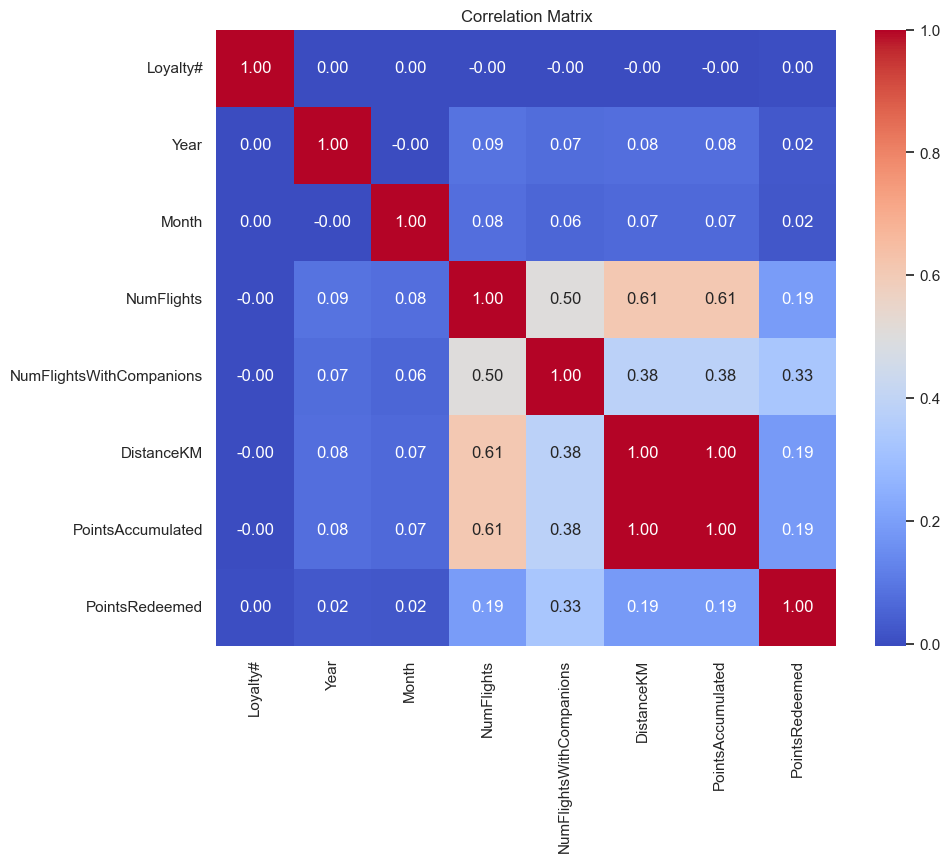

In [ ]:
correlation_matrix = flights.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Análise

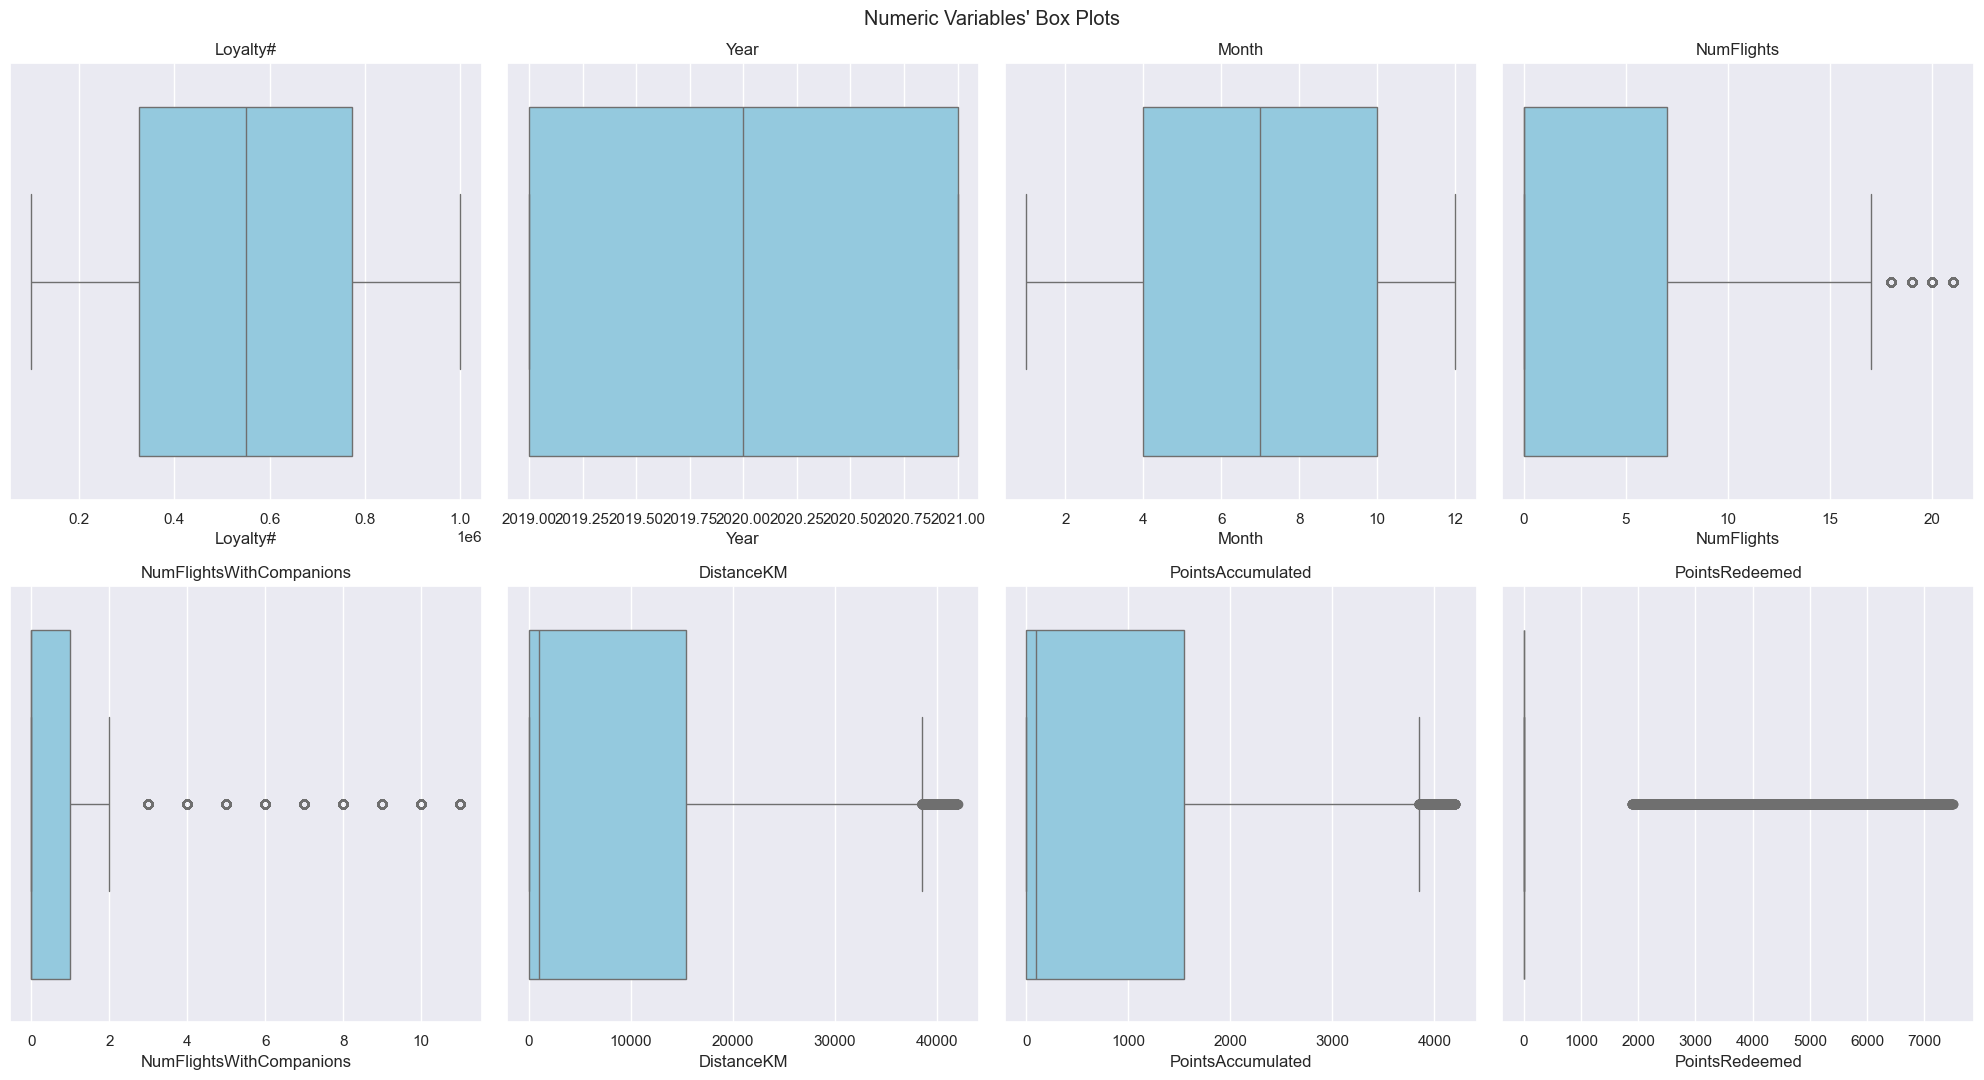

In [ ]:
from math import ceil
import os
# Plot ALL Numeric Variables' Histograms in one figure

sns.set() ## Reset to darkgrid

## What do these do?
sp_rows = 2
num_features = flights.select_dtypes(include='number').columns
sp_cols = ceil(len(num_features) / sp_rows)


# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 11),
                         tight_layout=True
                        )

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), num_features):
    sns.boxplot(x=flights[feat], ax=ax, color='skyblue')
    ax.set_title(feat)

    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

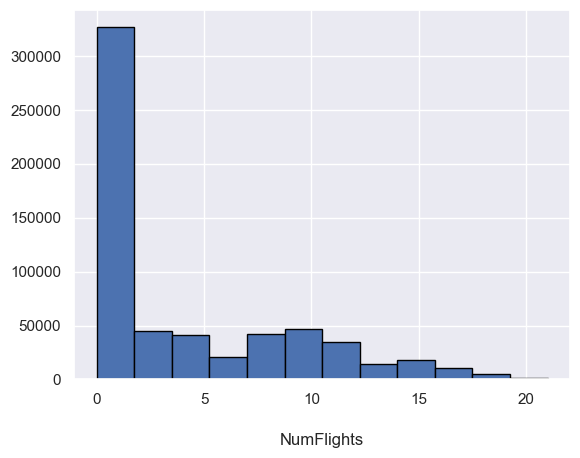

In [ ]:
plt.hist(flights['NumFlights'], bins=12, edgecolor='black')
plt.title('NumFlights', y=-0.2)
plt.show()

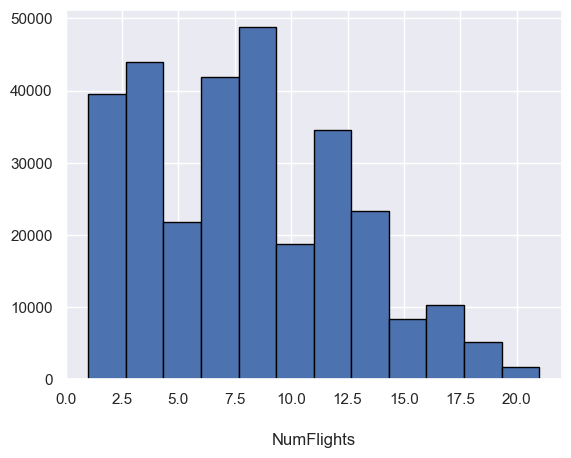

In [ ]:
plt.hist(flights[flights['NumFlights']>0]['NumFlights'], bins=12, edgecolor='black')
plt.title('NumFlights', y=-0.2)
plt.show()

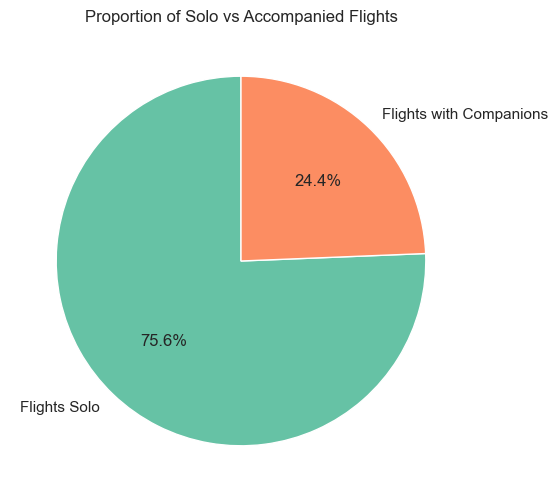

In [ ]:
# Relation Between Number of Flights and Number of Flights with Companions
flights['NumSoloFlights'] = flights['NumFlights'] - flights['NumFlightsWithCompanions']
flights_with_companions = flights['NumFlightsWithCompanions'].sum()
flights_solo = flights['NumSoloFlights'].sum()

# Data
values = [flights_solo, flights_with_companions]
labels = ['Flights Solo', 'Flights with Companions']
colors = ['#66c2a5', '#fc8d62']  # optional colors

# Plot
plt.figure(figsize=(6,6))
plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Proportion of Solo vs Accompanied Flights')
plt.show()


As we can see in the pie chart above, the majority of the flights were taken alone, representing 75.6% of them, while only 24.4% of the flights were taken with companions.

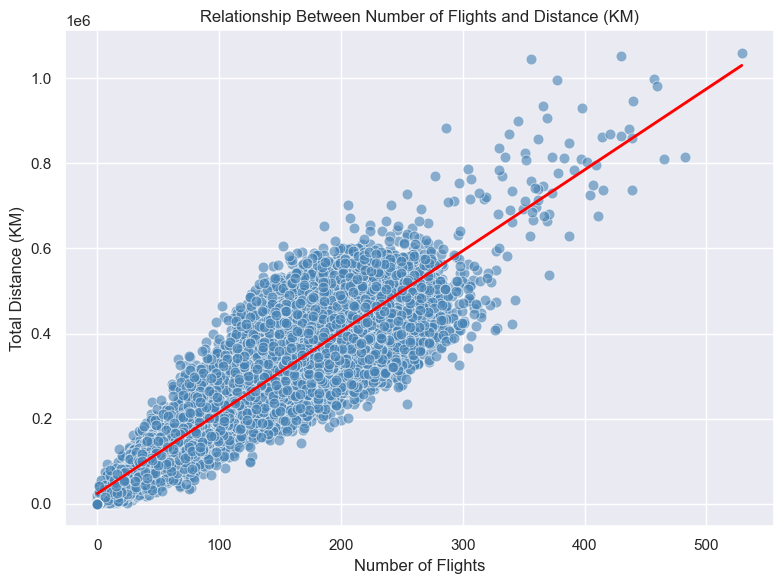

In [ ]:
plot_data = flights.groupby('Loyalty#', as_index=False).sum(numeric_only=True)

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=plot_data,
    x='NumFlights',
    y='DistanceKM',
    alpha=0.6,           # transparency for overlapping points
    s=60,                # point size
    color='steelblue'    # or use a colormap via hue
)

# Add a regression (trend) line
sns.regplot(
    data=plot_data,
    x='NumFlights',
    y='DistanceKM',
    scatter=False,        # hide duplicate points
    color='red',          # line color
    line_kws={'linewidth':2}
)

plt.title('Relationship Between Number of Flights and Distance (KM)')
plt.xlabel('Number of Flights')
plt.ylabel('Total Distance (KM)')
plt.tight_layout()
plt.show()



As we can see in the scatter plot above there is a positive and linear correlation between the number of flights and the number of flights with companions. This means that as the number of flights increases, the number of flights with companions also tends to increase. However, the relationship is not very strong, as there are many points scattered around the trend line.
We can also observe the costumers that fly more also tend to fly bigger distances.

<Axes: xlabel='PointsAccumulated', ylabel='PointsRedeemed'>

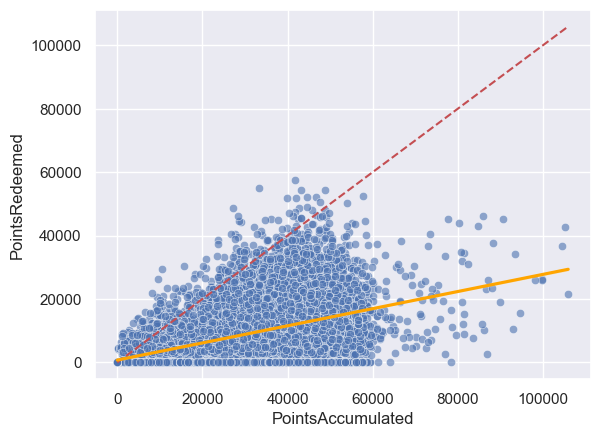

In [ ]:
data_plot = flights.groupby('Loyalty#', as_index=False).sum(numeric_only=True)

max_val = max(data_plot['PointsAccumulated'].max(), data_plot['PointsRedeemed'].max())

sns.scatterplot(data=data_plot, x='PointsAccumulated', y='PointsRedeemed', alpha=0.6)
plt.plot([0, max_val], [0, max_val], 'r--', label='y = x')
sns.regplot(data=data_plot, x='PointsAccumulated', y='PointsRedeemed', scatter=False, color='orange')


The customers above the x=y line are the ones that redeemed more points than they accumulated. We can look at them as potential outliers, those are the 458 customers we mentioned before. Maybe with the data in the customers dataset we can understand better why this happened.

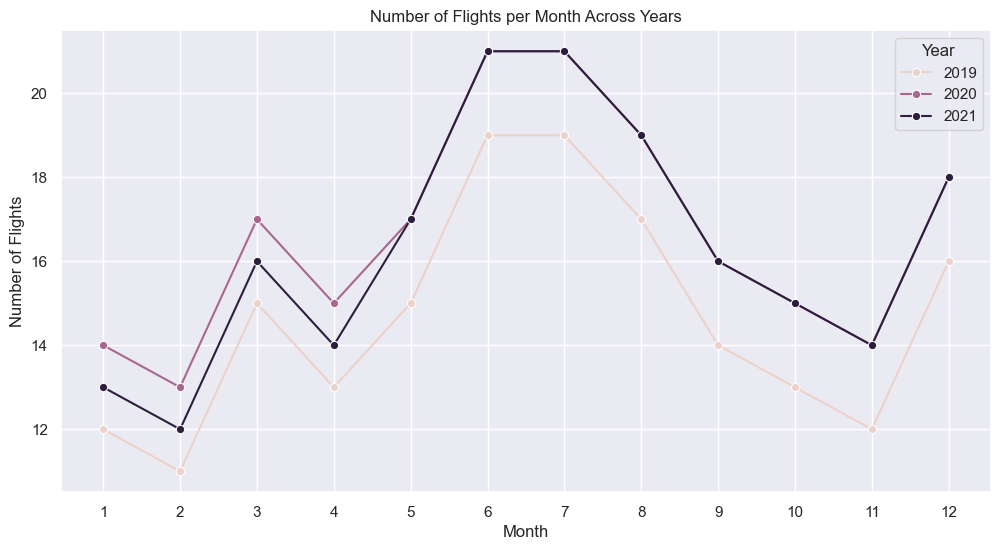

In [ ]:
monthly_data = flights.groupby(['Year', 'Month'], as_index=False)['NumFlights'].nunique()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_data, x='Month', y='NumFlights', hue='Year', marker='o')
plt.xticks(range(1,13))
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per Month Across Years')
plt.show()


The months with the highest number of flights are June and July, as it was expected since those are summer months in Canada, where people tend to travel more, since they also coincide with school vacations. The month with the lowest number of flights is February, which is also expected since it is a winter month and there are no holidays, so people tend to travel less during this time of the year.


Strangely the year with the highest number of flights is 2020, which is unexpected since it was the year of quarantines and travel restrictions due to the pandemic of COVID-19. However, it is possible that the data includes flights that were cancelled, and that people who weren't able to take the flights booked before the restrictions are included in the numbers, which could explain the higher number of flights in 2020 compared to other years.